In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from convex_adversarial import DualNetBounds
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import random
np.random.seed(1)
torch.manual_seed(23)
epsilon = 0.5
h = [2,3,2]
relaxation_dict = dict()

In [26]:
def make_layers(h):
    layers = []
    for i in range(1, len(h)):
        layers += [nn.Linear(h[i-1], h[i])]
        if i != len(h)-1: layers += [nn.ReLU()]
    return nn.Sequential(*layers)
net = make_layers(h)
print net

Sequential(
  (0): Linear(in_features=2, out_features=3)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=2)
)


In [27]:
def create_variables(net, h):
    names = []
    for k, h_dim in enumerate(h):
        t1 = ['z^'+'_'+str(k+1)+'_'+str(i) for i in range(1, 1+h_dim)]
        t2 = ['z'+'_'+str(k+1)+'_'+str(i) for i in range(1, 1+h_dim)]
        if k != 0: names.extend(t1)
        if k != len(h)-1: names.extend(t2)
    print names
    return names
vname = create_variables(net, h)

['z_1_1', 'z_1_2', 'z^_2_1', 'z^_2_2', 'z^_2_3', 'z_2_1', 'z_2_2', 'z_2_3', 'z^_3_1', 'z^_3_2']


In [28]:
def draw_adv(net, X):
    output = net(Variable(X))
    OX = X.clone()
    k=30
    z_hat = []
    for i in range(-k, k+1):
        dx = float(i) / k * epsilon
        for j in range(-k, k+1):
            dy = float(j) / k * epsilon
            X[:, 0] = OX[:, 0] + dx
            X[:, 1] = OX[:, 1] + dy
            z_hat.append(net(Variable(X)).data.numpy())
        
    z_hat = np.vstack(z_hat)    
    plt.plot(output.data.numpy()[:,0], output.data.numpy()[:,1], 'ro')
    plt.scatter(z_hat[:,0], z_hat[:,1], cmap="coolwarm", s=10)


x = [(0.417022  ,  0.72032449)]
X = torch.Tensor(np.array(x))
draw_adv(net, X)
#plt.show()

In [29]:
def vname2index(vname, i, j, hat=False, return_vname = False):
    if hat: s = 'z^_'+str(i)+'_'+str(j)
    else: s = 'z_'+str(i)+'_'+str(j)
    if return_vname: return s
    return vname.index(s)

In [30]:
#given network, transform it to linear constraints
def make_constraints(net, vname, h, x):
    x1, x2 = x[0][0], x[0][1]
    X = torch.Tensor(np.array(x))
    dual = DualNetBounds(net, Variable(X), epsilon)

    lts, ltb, eqs, eqb = [], [], [], []
    W = [p.data.numpy() for i, p in enumerate(net.parameters()) if i%2 == 0]
    b = [p.data.numpy() for i, p in enumerate(net.parameters()) if i%2 == 1]
    #affine layer: equations
    for i in range(1, len(h)):
        for j in range(1, h[i]+1):
            eqs_ = [0]*len(vname)
            x = vname2index(vname, i+1, j, True)
            eqs_[x] = -1
            for k in range(h[i-1]):
                y = vname2index(vname, i, k+1, False)
                eqs_[y] = W[i-1][j-1][k]
            eqb_ = -b[i-1][j-1]

            eqs.append(eqs_)
            eqb.append(eqb_)

    #relu layer: three types
    for i in range(1, len(h)-1):
        upper = dual.zu[i-1].data.numpy()
        lower = dual.zl[i-1].data.numpy()
        for j in range(1, h[i]+1):
            eqs_ = [0]*len(vname)
            hat_index = vname2index(vname, i+1, j, True)
            no_hat_id = vname2index(vname, i+1, j, False)
            if upper[j-1] <= 0:
                eqs_[no_hat_id] = 1
            elif lower[j-1] >= 0:
                eqs_[no_hat_id] = 1
                eqs_[hat_index] = -1
            else:
                lts_1, lts_2, lts_3 = [0]*len(vname), [0]*len(vname), [0]*len(vname)
                lts_1[no_hat_id] = -1
                lts_2[no_hat_id], lts_2[hat_index] = -1, 1
                lts_3[no_hat_id], lts_3[hat_index] = upper[j-1]-lower[j-1], -upper[j-1]
                lts += [lts_1, lts_2, lts_3]
                ltb += [0, 0, -upper[j-1]*lower[j-1]]
                relaxation_dict[(i+1,j)] = vname2index(vname, i+1, j, return_vname=True)
                continue

            eqs.append(eqs_)
            eqb.append(0)
    
    z11_bnd = (x1-epsilon, x1+epsilon)
    z12_bnd = (x2-epsilon, x2+epsilon)
    ubnd = (-np.inf, np.inf)
    bounds = [z11_bnd, z12_bnd]
    bounds += [ubnd]*(len(vname)-2)
    
    return lts, ltb, eqs, eqb, bounds

lts, ltb, eqs, eqb, bounds = make_constraints(net, vname, h, x)

In [31]:
def draw_outer(lts, ltb, eqs, eqb, bounds, color = 'r'):
    vnum = len(vname)
    pool = []
    su = 10
    for i in range(0,su*vnum):
        k = i / su
        c =  [0]*k + random.sample(xrange(-100, 100), vnum-k)
        res = linprog(c, lts, ltb, eqs, eqb, 
            bounds=bounds,
            options={'disp': False, 'bland': False, 'tol': 1e-12, 'maxiter': 1000})
        pool.append(tuple(res.x[-2:]))
    pool = set(pool)
    drawGraphandOuter(pool,color)

draw_outer(lts, ltb, eqs, eqb, bounds)
#plt.show()

Vertices Set That You Can Split: ['z_2_3']


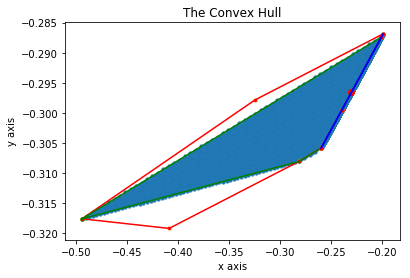

In [32]:
def split(split_vertex, eqs, eqb, bnd):
    if not relaxation_dict.has_key(split_vertex): 
        print 'Error: Please choose a vertex can be split!'
        exit(1)
    print 'Vertices Set That You Can Split:', relaxation_dict.values()

    eqs_1, eqs_2, eqb_1, eqb_2, bnd_1, bnd_2 = list(eqs), list(eqs), list(eqb), list(eqb), list(bnd), list(bnd)
    # 1. >=0
    eqs_1_, eqs_2_ = [0]*len(vname), [0]*len(vname)
    hat_index = vname2index(vname, split_vertex[0], split_vertex[1], True)
    no_hat_id = vname2index(vname, split_vertex[0], split_vertex[1], False)
    eqs_1_[no_hat_id] = 1
    eqs_1_[hat_index] = -1
    eqs_1.append(eqs_1_), eqb_1.append(0)
    bnd_1[hat_index] = (0, np.inf)
    # 2. < 0
    eqs_2_[no_hat_id] = 1
    eqs_2.append(eqs_2_), eqb_2.append(0)
    bnd_2[hat_index] = (-np.inf, 0)

    return (eqs_1, eqb_1, bnd_1), (eqs_2, eqb_2, bnd_2)

r1, r2 = split((2,3), eqs, eqb, bounds)
eqs_1, eqb_1, bnd_1 = r1
eqs_2, eqb_2, bnd_2 = r2
draw_outer(lts, ltb, eqs_1, eqb_1, bnd_1, 'g')
draw_outer(lts, ltb, eqs_2, eqb_2, bnd_2, 'b')
plt.show()

In [41]:
np.random.seed(1)
torch.manual_seed(231)
epsilon = 0.5
h = [2,5,2]
relaxation_dict = dict()

net = make_layers(h)
print net

vname = create_variables(net, h)

Sequential(
  (0): Linear(in_features=2, out_features=5)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2)
)
['z_1_1', 'z_1_2', 'z^_2_1', 'z^_2_2', 'z^_2_3', 'z^_2_4', 'z^_2_5', 'z_2_1', 'z_2_2', 'z_2_3', 'z_2_4', 'z_2_5', 'z^_3_1', 'z^_3_2']


In [42]:
x = [(0.417022  ,  0.72032449)]
X = torch.Tensor(np.array(x))
draw_adv(net, X)
lts, ltb, eqs, eqb, bounds = make_constraints(net, vname, h, x)
draw_outer(lts, ltb, eqs, eqb, bounds)

#plt.show()

Vertices Set That You Can Split: ['z_2_4', 'z_2_2']


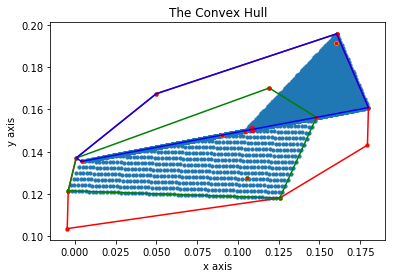

In [43]:

r1, r2 = split((2,2), eqs, eqb, bounds)
eqs_1, eqb_1, bnd_1 = r1
eqs_2, eqb_2, bnd_2 = r2
draw_outer(lts, ltb, eqs_1, eqb_1, bnd_1, 'g')
draw_outer(lts, ltb, eqs_2, eqb_2, bnd_2, 'b')
plt.show()